## Prepare Data

Get seasons wise kickers and pro bowl data

In [2]:
import mysql.connector
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.mlab as mlab
from mysql.connector import errorcode
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.html.widgets import *
import plotly as py
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import os
import json
import time
import pickle
import requests
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import configparser

%matplotlib inline

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [ ]:
config = configparser.ConfigParser()
config.read('dbConfig.ini')
dbConfig = config['ConnectionString']['dbConfig']

QUERY = """SELECT 
        FKICKER,COND,SURF,      
        Percentage.GID,
        GAME.SEAS AS SEASON,
        CAST(((SUM(SUCCESS) / COUNT(*)) * 100) AS decimal(38,2)) AS SUCCESS_PRCNTG,
        CAST(((SUM(BLOCKED) / COUNT(*)) * 100) AS decimal(38,2)) AS BLOCKED_PRCNTG,
        CAST(COUNT(*) AS decimal(38,5)) AS PLAY_COUNT,
        CAST(CASE
            WHEN SUM(HIGH_PRESSURE) = 0 THEN 0
            ELSE ((SUM(HIGH_PRESSURE_SUCCESS) / SUM(HIGH_PRESSURE)) * 100)
        END AS decimal(38,5)) AS HIGH_PRESSURE_SUCCESS_PRCNTG,
        CAST(SUM(HIGH_PRESSURE) AS decimal(38,5)) AS HIGH_PRESSURE_COUNT,
        CAST(CASE
            WHEN SUM(LONG_DIST) = 0 THEN 0
            ELSE ((SUM(LONG_DIST_SUCCESS) / SUM(LONG_DIST)) * 100)
        END AS decimal(38,5)) AS LONG_DIST_SUCCESS_PRCNTG, 
        CAST(SUM(LONG_DIST) AS decimal(38,5)) AS LONG_DIST_COUNT,
        TEMP,
        HUMD,
        WSPD,
        (GAME.SEAS - PLAYER.start) AS YEARS_PLAYED,
        height,
        weight,
        PLAYER.forty,
        PLAYER.bench,
        PLAYER.vertical,
        PLAYER.broad,
        PLAYER.shuttle,
        PLAYER.cone,
        PLAYER.arm,
        PLAYER.hand,
        PLAYER.dcp,
        DPOS AS DRAFT_POSITION,
        CAST((SELECT 
                (TO_DAYS(NOW()) - TO_DAYS(STR_TO_DATE(dob, '%m/%d/%Y'))) / 365
            FROM
                db_nfl.PLAYER P
            WHERE
                P.player = FKICKER) AS decimal(38,5)) AS AGE_YEARS,
        CASE WHEN PRO_BOWL.ProBowl_Level IS NULL THEN 0 ELSE 1 END AS INPROBOWLTEAM
    FROM
        (SELECT 
            FGXP,
                PBP.GID,
                PBP.FKICKER,
                CASE
                    WHEN GOOD = 'Y' THEN 1
                    ELSE 0
                END AS SUCCESS,
                CASE
                    WHEN UPPER(DETAIL) LIKE '%BLOCKED%' THEN 1
                    ELSE 0
                END AS BLOCKED,
                CASE
                    WHEN
                        QTR IN ('2' , '4') AND MIN <= 2
                            AND (PTSO - PTSD) >= - 3
                    THEN
                        1
                    ELSE 0
                END AS HIGH_PRESSURE,
                CASE
                    WHEN
                        QTR IN ('2' , '4') AND MIN <= 2
                            AND (PTSO - PTSD) >= - 3
                            AND GOOD = 'Y'
                    THEN
                        1
                    ELSE 0
                END AS HIGH_PRESSURE_SUCCESS,
                CASE
                    WHEN DIST >= 50 THEN 1
                    ELSE 0
                END AS LONG_DIST,
                CASE
                    WHEN DIST >= 50 AND GOOD = 'Y' THEN 1
                    ELSE 0
                END AS LONG_DIST_SUCCESS,
                DIST - (100 - CASE
                    WHEN YFOG = '' THEN '98'
                    ELSE YFOG
                END) AS YDS_BEHIND_LOS
        FROM
            db_nfl.PBP
        LEFT OUTER JOIN db_nfl.PLAYER PLAYER ON PBP.FKICKER = PLAYER.PLAYER
        WHERE POS1 = 'K' ) AS Percentage
            LEFT OUTER JOIN
        db_nfl.PLAYER PLAYER ON Percentage.FKICKER = PLAYER.PLAYER
            LEFT OUTER JOIN
        db_nfl.GAME ON Percentage.GID = GAME.GID 
        LEFT OUTER JOIN
        db_nfl.PRO_BOWL ON PRO_BOWL.PLAYER_ID = PLAYER.PLAYER AND GAME.SEAS = ProBowl_Year        
    GROUP BY FKICKER , GAME.GID
    ORDER BY FKICKER , GAME.GID;"""

FEATURES = ['FKICKER','COND','SURF','GID','SEASON','SUCCESS_PRCNTG','BLOCKED_PRCNTG','PLAY_COUNT',
        'HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT',
        'TEMP','HUMD','WSPD', 
        'YEARS_PLAYED','height','weight','forty','bench',
        'vertical','broad','shuttle','cone',
        'arm','hand','dcp','DRAFT_POSITION','AGE_YEARS','INPROBOWLTEAM']

def fetch_data():   
    try:
        cnx = mysql.connector.connect(**eval(dbConfig))
        cursor = cnx.cursor()
        #Let's read all the rows in the table
        cursor.execute(QUERY)
        #specify the attributes that you want to display
        df = DataFrame(cursor.fetchall())    
        df.columns = FEATURES
        cnx.commit()
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    else:
        
        return df
        cursor.close()
        cnx.close()
DATA = fetch_data()     

In [3]:
DATA.head(3)

,FKICKER,COND,SURF,GID,SEASON,SUCCESS_PRCNTG,BLOCKED_PRCNTG,PLAY_COUNT,HIGH_PRESSURE_SUCCESS_PRCNTG,HIGH_PRESSURE_COUNT,...,vertical,broad,shuttle,cone,arm,hand,dcp,DRAFT_POSITION,AGE_YEARS,INPROBOWLTEAM
0,AD-0800,Mostly Cloudy,AstroTurf,14,2000,100.00,0.00,3.00000,0.00000,0.00000,...,0.0,0,0.0,0.0,0,0.0,0,0,56.31781,0
1,AD-0800,Cloudy,Grass,28,2000,100.00,0.00,3.00000,100.00000,2.00000,...,0.0,0,0.0,0.0,0,0.0,0,0,56.31781,0
2,AD-0800,Chance Rain,AstroTurf,54,2000,100.00,0.00,5.00000,100.00000,1.00000,...,0.0,0,0.0,0.0,0,0.0,0,0,56.31781,0


### Missing value treatement

In [4]:
#missing value check
DATA.isnull().sum()

FKICKER                         0
COND                            0
SURF                            0
GID                             0
SEASON                          0
SUCCESS_PRCNTG                  0
BLOCKED_PRCNTG                  0
PLAY_COUNT                      0
HIGH_PRESSURE_SUCCESS_PRCNTG    0
HIGH_PRESSURE_COUNT             0
LONG_DIST_SUCCESS_PRCNTG        0
LONG_DIST_COUNT                 0
TEMP                            0
HUMD                            0
WSPD                            0
YEARS_PLAYED                    0
height                          0
weight                          0
forty                           0
bench                           0
vertical                        0
broad                           0
shuttle                         0
cone                            0
arm                             0
hand                            0
dcp                             0
DRAFT_POSITION                  0
AGE_YEARS                       0
INPROBOWLTEAM 

## Feature analysis & selection

### Check if it is separable classficiation problem

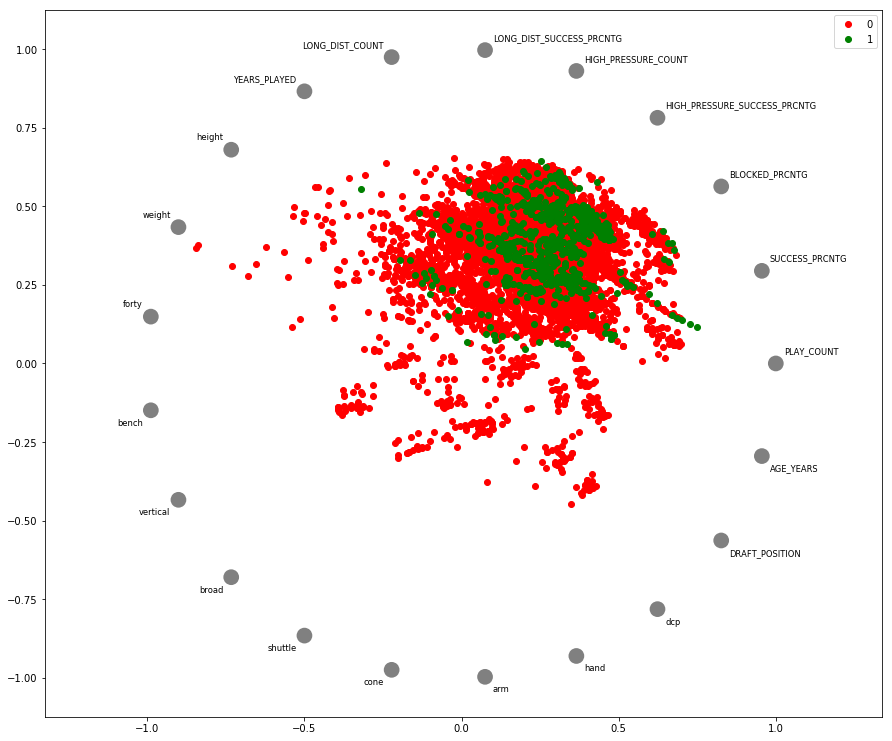

In [5]:
#check if it is separable classficiation problem
DATA[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT','YEARS_PLAYED','AGE_YEARS']]=DATA[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT','YEARS_PLAYED','AGE_YEARS']].apply(pd.to_numeric)
#DATA = DATA[DATA['PLAY_COUNT']>55]
#DATA = DATA[DATA['SUCCESS_PRCNTG']>80]
from pandas.plotting import radviz
plt.figure(figsize=(15,13))
radviz(DATA[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT','YEARS_PLAYED','height','weight','forty','bench','vertical','broad','shuttle','cone','arm','hand','dcp','DRAFT_POSITION','AGE_YEARS','INPROBOWLTEAM']], 'INPROBOWLTEAM', color=['red','green'])

This looks like good separaable classification problem, we can also see the success percentage and counts have more impact on 1s.

0    8784
1     705
Name: INPROBOWLTEAM, dtype: int64

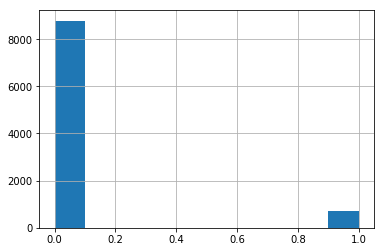

In [6]:
DATA['INPROBOWLTEAM'].hist()
DATA['INPROBOWLTEAM'].value_counts()

In [7]:
# check correlation among quantitaive features and pick only one feature out of two too correlated features
corr_matrix = DATA.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('shuttle', 'cone'), ('arm', 'hand')]

Select features after correaltion check and remove 'TEMP', 'HUMD', 'WSPD' becuase we will use COND column which has same data

In [8]:
DATA.columns

Index(['FKICKER', 'COND', 'SURF', 'GID', 'SEASON', 'SUCCESS_PRCNTG',
       'BLOCKED_PRCNTG', 'PLAY_COUNT', 'HIGH_PRESSURE_SUCCESS_PRCNTG',
       'HIGH_PRESSURE_COUNT', 'LONG_DIST_SUCCESS_PRCNTG', 'LONG_DIST_COUNT',
       'TEMP', 'HUMD', 'WSPD', 'YEARS_PLAYED', 'height', 'weight', 'forty',
       'bench', 'vertical', 'broad', 'shuttle', 'cone', 'arm', 'hand', 'dcp',
       'DRAFT_POSITION', 'AGE_YEARS', 'INPROBOWLTEAM'],
      dtype='object')

In [9]:
FEATURES_SELECTED =['FKICKER', 'GID', 'SEASON', 'COND', 'SURF','SUCCESS_PRCNTG',
       'BLOCKED_PRCNTG', 'PLAY_COUNT', 'HIGH_PRESSURE_SUCCESS_PRCNTG',
       'HIGH_PRESSURE_COUNT', 'LONG_DIST_SUCCESS_PRCNTG', 'LONG_DIST_COUNT',
       'YEARS_PLAYED', 'INPROBOWLTEAM']
DATA=DATA[FEATURES_SELECTED]

FEATURES_SELECTED =['FKICKER', 'GID', 'SEASON', 'COND', 'SURF','SUCCESS_PRCNTG',
       'BLOCKED_PRCNTG', 'PLAY_COUNT', 'HIGH_PRESSURE_SUCCESS_PRCNTG',
       'HIGH_PRESSURE_COUNT', 'LONG_DIST_SUCCESS_PRCNTG', 'LONG_DIST_COUNT',
       'YEARS_PLAYED', 'height', 'weight', 'forty',
       'bench', 'vertical', 'broad', 'shuttle', 'arm', 'dcp',
       'DRAFT_POSITION', 'INPROBOWLTEAM']
DATA=DATA[FEATURES_SELECTED]

### Analyse Weather conditions

In [10]:
DATA["COND"].value_counts()

Sunny            1937
Cloudy           1531
Dome             1521
Partly Cloudy     972
Clear             903
Closed Roof       695
Mostly Cloudy     389
Rain              318
Chance Rain       279
Mostly Sunny      230
                  192
Partly Sunny      144
Light Rain        116
Fair               71
Snow               67
Light Snow         37
Flurries           28
Hazy               26
Foggy              13
Covered Roof        4
Cold                4
Partly CLoudy       2
Light Showers       2
Overcast            2
Showers             2
Windy               2
Thunderstorms       2
Name: COND, dtype: int64

too many weather conditions, map these conditions to fewer categories

NORMAL_WEATHER    9053
HARD_WEATHER       436
Name: COND, dtype: int64

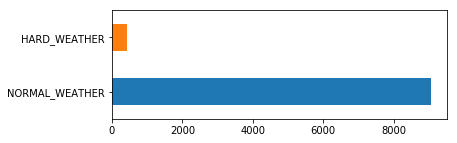

In [11]:
WeatherConditionsDifficultyLevel = {
    'NORMAL_WEATHER' :['Closed Roof','Covered Roof','Dome','Clear','Cloudy',
                       'Partly Cloudy','Mostly Cloudy','Fair','Partly CLoudy',
                       'Sunny','Mostly Sunny','Partly Sunny','Chance Rain','Light Rain','Flurries','Light Snow',
                       'Light Showers',''],
    'HARD_WEATHER':['Rain','Showers','Snow','Foggy','Hazy','Thunderstorms','Cold',
                     'Windy','Overcast']
}

def get_weather_category(dict, text):
    for k,v in dict.items():        
        for val in dict[k]:
            if(val == text):
                return k
    return text
DATA["COND"] = DATA.apply(lambda row: get_weather_category(WeatherConditionsDifficultyLevel, row['COND']), axis=1)
plt.figure(figsize=(6,2))
DATA["COND"].value_counts().plot(kind='barh')
DATA["COND"].value_counts()

In [12]:
DATA["COND"] = (DATA["COND"].str.contains('Hard') == True).astype(int)

### Analyse SURF

In [13]:
DATA["SURF"].value_counts()

Grass                   5395
FieldTurf               1712
AstroTurf               1186
UBU Speed Series S5M     422
MomentumTurf             260
DD GrassMaster           223
AstroPlay                135
A Turf Titan             103
NeXTurf                   20
SportGrass                15
Sportex                   14
Artificial Turf            4
Name: SURF, dtype: int64

In [14]:
DATA["SURF"] = (DATA["SURF"].str.contains('Turf') == True).astype(int)

In [15]:
DATA.head(10)

,FKICKER,GID,SEASON,COND,SURF,SUCCESS_PRCNTG,BLOCKED_PRCNTG,PLAY_COUNT,HIGH_PRESSURE_SUCCESS_PRCNTG,HIGH_PRESSURE_COUNT,LONG_DIST_SUCCESS_PRCNTG,LONG_DIST_COUNT,YEARS_PLAYED,INPROBOWLTEAM
0,AD-0800,14,2000,0,1,100.00,0.0,3.0,0.00000,0.0,0.0,0.0,16.0,0
1,AD-0800,28,2000,0,0,100.00,0.0,3.0,100.00000,2.0,0.0,0.0,16.0,0
2,AD-0800,54,2000,0,1,100.00,0.0,5.0,100.00000,1.0,0.0,0.0,16.0,0
3,AD-0800,69,2000,0,0,80.00,0.0,5.0,50.00000,2.0,0.0,0.0,16.0,0
4,AD-0800,77,2000,0,0,83.33,0.0,6.0,100.00000,1.0,0.0,0.0,16.0,0
5,AD-0800,100,2000,0,0,83.33,0.0,6.0,0.00000,0.0,0.0,0.0,16.0,0
6,AD-0800,103,2000,0,0,100.00,0.0,2.0,100.00000,1.0,0.0,0.0,16.0,0
7,AD-0800,128,2000,0,0,100.00,0.0,5.0,100.00000,2.0,0.0,0.0,16.0,0
8,AD-0800,141,2000,0,0,75.00,0.0,4.0,100.00000,2.0,0.0,0.0,16.0,0
9,AD-0800,156,2000,0,0,60.00,0.0,5.0,33.33333,3.0,0.0,0.0,16.0,0


## Prepare data for modeling

In [16]:
# get quantitaive features
dt = DATA
dt.apply(pd.to_numeric, errors='ignore')
import sklearn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#data for modeling , before 2016 data
dt_modeling = dt[dt['SEASON'] <2016].iloc[:,3:]
#train_data=scaler.fit_transform(dt_modeling.iloc[:, 0:-1])
train_data=dt_modeling.iloc[:, 0:-1]
#dt_modeling_data = pd.DataFrame(train_data,index=train_data[:,0])
dt_modeling_data=dt_modeling.iloc[:, 0:-1]
target_modeling =dt_modeling.iloc[:, -1]

#data for out of bag testing of model - 2016/2017 dta
dt_predict = dt[dt['SEASON']>2016].iloc[:,3:]
dt_predict_data = dt_predict.iloc[:, 0:-1]
target_predict = dt_predict.iloc[:, -1]

In [17]:
#regularization
model = Lasso(alpha=.03)
model.fit(dt_modeling_data, target_modeling)
print(list(zip(dt_modeling_data, model.coef_.tolist())))
sfm = SelectFromModel(model)
sfm.fit(dt_modeling_data, target_modeling)
print(list(dt_modeling_data.iloc[:, sfm.get_support(indices=True)]))

model = Ridge()
model.fit(dt_modeling_data, target_modeling)
print(list(zip(dt_modeling_data, model.coef_.tolist())))
sfm = SelectFromModel(model)
sfm.fit(dt_modeling_data, target_modeling)
print(list(dt_modeling_data.iloc[:, sfm.get_support(indices=True)]))

model = ElasticNet()
model.fit(dt_modeling_data, target_modeling)
print(list(zip(dt_modeling_data, model.coef_.tolist())))
sfm = SelectFromModel(model)
sfm.fit(dt_modeling_data, target_modeling)
print(list(dt_modeling_data.iloc[:, sfm.get_support(indices=True)]))


[('COND', 0.0), ('SURF', 0.0), ('SUCCESS_PRCNTG', 0.0007346080878422048), ('BLOCKED_PRCNTG', -0.0), ('PLAY_COUNT', 0.0), ('HIGH_PRESSURE_SUCCESS_PRCNTG', 0.00011988917760212167), ('HIGH_PRESSURE_COUNT', 0.0), ('LONG_DIST_SUCCESS_PRCNTG', 0.00019738833489087824), ('LONG_DIST_COUNT', -0.0), ('YEARS_PLAYED', -0.00025433103123821346)]
['SUCCESS_PRCNTG', 'HIGH_PRESSURE_SUCCESS_PRCNTG', 'LONG_DIST_SUCCESS_PRCNTG', 'YEARS_PLAYED']
[('COND', 0.0), ('SURF', 0.003336349796733497), ('SUCCESS_PRCNTG', 0.0007127601625260767), ('BLOCKED_PRCNTG', 2.3673442044294678e-06), ('PLAY_COUNT', 0.013212552267388178), ('HIGH_PRESSURE_SUCCESS_PRCNTG', 5.241925498083056e-05), ('HIGH_PRESSURE_COUNT', -0.010832288653749744), ('LONG_DIST_SUCCESS_PRCNTG', 0.00034384910620139704), ('LONG_DIST_COUNT', -0.014543974333683068), ('YEARS_PLAYED', -0.001376381805376518)]
['PLAY_COUNT', 'HIGH_PRESSURE_COUNT', 'LONG_DIST_COUNT']
[('COND', 0.0), ('SURF', 0.0), ('SUCCESS_PRCNTG', 0.0), ('BLOCKED_PRCNTG', -0.0), ('PLAY_COUNT', 0

In [18]:
import time 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Identify our data and target 
X = dt_modeling_data
y = target_modeling

# Create random train and test splits to avoid bais and overfitting
splits = tts(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = splits

In [19]:
results=[]
names=[]

def fit_model(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    start = time.time()
    model.fit(X_train, y_train)
    duration = time.time() - start 
    score = model.score(X_test, y_test)
    
    print("{} fit in {:0.2f} seconds score: {:0.4f}".format(model.__class__.__name__, duration, score))
    #print(model.get_params()) 
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    scoring = 'accuracy'
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    #print(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)


KNeighborsClassifier fit in 0.03 seconds score: 0.9223
DecisionTreeClassifier fit in 0.00 seconds score: 0.9170
SVC fit in 6.46 seconds score: 0.9223
AdaBoostClassifier fit in 7.01 seconds score: 0.9087


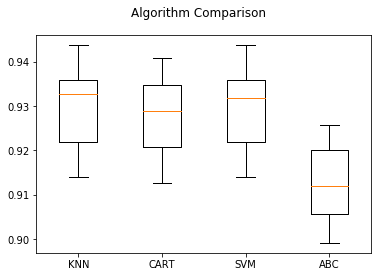

In [20]:
# prepare models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier


# Training classifiers
CART = DecisionTreeClassifier(max_depth=6)
KNN = KNeighborsClassifier(n_neighbors=12)
SV = SVC(kernel='rbf', probability=True)
VC = VotingClassifier(estimators=[('dt', CART), ('knn', KNN), ('svc', SV)], voting='soft', weights=[3,3,3])

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                         algorithm="SAMME",
                         n_estimators=500)

models = []
models.append(('KNN', KNN))
models.append(('CART', CART))
models.append(('SVM', SV))
#models.append(('VC', VC))
models.append(('ABC', ABC))

    
for name,model in models:
    fit_model(model)    
    
    # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()  

In [26]:
seas=2015
dt_predict = dt[dt['SEASON']==seas].iloc[:,3:]
dt_predict_data = dt_predict.iloc[:, 0:-1]
target_predict = dt_predict.iloc[:, -1]

X = dt_predict_data 
y = target_predict

# 2016 - 36 0:33 1:3
# 2017 - 43 0:40 1:3

def predict_model(model):
    yhat = model.predict(dt_predict_data)
    #print(classification_report(y, yhat))
    d= DATA.loc[(DATA["SEASON"]==seas)]
    d['yhat'] = yhat
    #print("Season: {}, 0s: {}, 1s:{}".format(seas,len(X[X['INPROBOWLTEAM'] ==0]),len(X[X['INPROBOWLTEAM'] ==1])))
    unmatched_results = d.loc[( d['yhat'] != d['INPROBOWLTEAM'])]
    matched_results = d.loc[( d['yhat'] == d['INPROBOWLTEAM'])]
    print("unmatched: count {}, ".format(len(unmatched_results), unmatched_results))
    print("Matched: count {},".format(len(matched_results), matched_results))
    
    #print(d.loc[( d['yhat'] != d['INPROBOWLTEAM']),['FKICKER','GID','INPROBOWLTEAM','yhat']])
    print('Predicted players'.format(d.loc[( d['yhat'] == 1),'FKICKER'].unique()))
    print('Actual playerss'.format(d.loc[( d['INPROBOWLTEAM'] == 1),'FKICKER'].unique()))

    
    #print(len(DATA.loc[(DATA["SEASON"]==seas) & (DATA["INPROBOWLTEAM"] == yhat), "INPROBOWLTEAM"]))
    

for name, model in models:
    print('MODEL-'.format(name))
    predict_model(model)  

MODEL-
unmatched: count 50, 
Matched: count 478,
Predicted players
Actual playerss
MODEL-
unmatched: count 49, 
Matched: count 479,
Predicted players
Actual playerss
MODEL-
unmatched: count 50, 
Matched: count 478,
Predicted players
Actual playerss
MODEL-


C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



unmatched: count 39, 
Matched: count 489,
Predicted players
Actual playerss


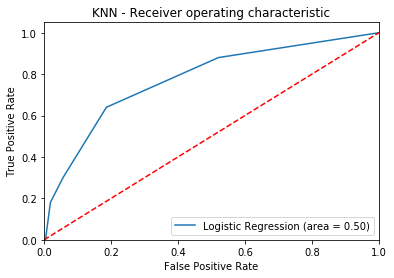

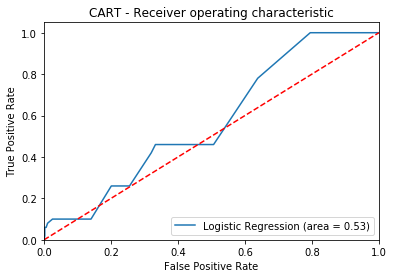

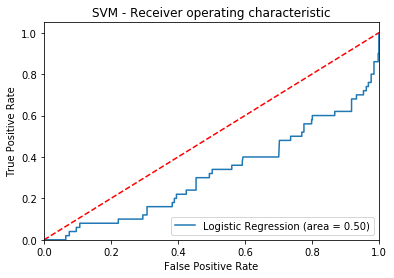

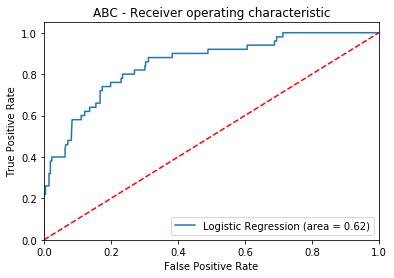

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

for name, model in models:
    logit_roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name + ' - Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [23]:
from sklearn.metrics import accuracy_score